In [6]:
# General Imports
import pandas as pd
import numpy as np
import seaborn as sns

In [7]:
# Data Imports
pilot_reviews_df = pd.read_csv("../data/trustpilot-reviews.csv", index_col=None, names=["rating", "review", "t", "name"], usecols=[0,1,2,3])
io_reviews_df = pd.read_csv("../data/reviews-io-reviews.csv", index_col=None, names=["rating", "review", "t", "name"])


# Add source column
io_reviews_df['source'] = 'reviewsio'
pilot_reviews_df['source'] = 'trustpilot'

# Fuse the datasets (dropping URL column as we only have it for one half)
# Keep an identifier on source dataset for plot reasons (i.e. add source column)
# The number of datapoints will depend if you are using newly scraped data or the reserved static one
fused_df = pd.concat([io_reviews_df, pilot_reviews_df])
fused_df.info() # Health Check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119 entries, 0 to 738
Data columns (total 5 columns):
rating    1119 non-null int64
review    1119 non-null object
t         1119 non-null object
name      1119 non-null object
source    1119 non-null object
dtypes: int64(1), object(4)
memory usage: 52.5+ KB


<h3> EDA focusing on review rating </h3>
<p>This section focuses on the review rating given by each reviewer. We will check FreeAgent's standing, the change in satisfaction over time (if any), and overall distributions. One focus will also be to identify a potential problem with unbalanced classes in terms of review rating given text (more on this in the sentiment/classification analysis part).
</p>

In [8]:
# The basic statistical breakdown (overall)
''
print("")
print("Summary Statistics for Entire Dataset: ")
print("")

print("#### Proportion of rating values: ")
print(fused_df.rating.value_counts('normalize'))
print("")

print("#### 5-Point summary: ")
print(fused_df.rating.describe())
print("")

# Subsets
print("")
print("Summary Statistics for Reviewsio Dataset: ")
print("")
print("#### Proportion of rating values: ", io_reviews_df.rating.value_counts('normalize'))
print("5-Point summary: ", io_reviews_df.rating.describe())
print("")

print("")
print("Summary Statistics for Trustpilot Dataset: ")
print("")
print("#### Proportion of rating values: ", pilot_reviews_df.rating.value_counts('normalize'))
print("5-Point summary: ", pilot_reviews_df.rating.describe())
print("")


Summary Statistics for Entire Dataset: 

#### Proportion of rating values: 
5    0.766756
4    0.143878
3    0.048257
1    0.025022
2    0.016086
Name: rating, dtype: float64

#### 5-Point summary: 
count    1119.00000
mean        4.61126
std         0.85532
min         1.00000
25%         5.00000
50%         5.00000
75%         5.00000
max         5.00000
Name: rating, dtype: float64


Summary Statistics for Reviewsio Dataset: 

#### Proportion of rating values:  5    0.715789
4    0.155263
3    0.068421
1    0.031579
2    0.028947
Name: rating, dtype: float64
5-Point summary:  count    380.000000
mean       4.494737
std        0.970528
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64


Summary Statistics for Trustpilot Dataset: 

#### Proportion of rating values:  5    0.792963
4    0.138024
3    0.037889
1    0.021651
2    0.009472
Name: rating, dtype: float64
5-Point summary:  count    739.000000
mean 

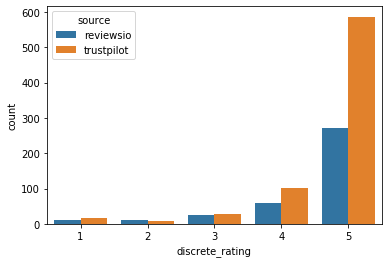

In [9]:
# Some plotting on rating distribution to hammer down the point
fused_df["discrete_rating"] = fused_df.rating.astype('category') # need categorical rating for plotting

ax = sns.countplot(x="discrete_rating", hue="source", data=fused_df)

# Class Imbalance: the good, the bad and the ugly.

This is of course wonderful! The product is without a doubt a hit, regardless of review source. Reviews coming from reviewsio seeem to have a slightly lower proportion of high grades in comparsion with trustpilot reviews but overall there is a clear majority of 5's. Kudos!

While this is great from a product standpoint, it does make the job of data scientist slightly trickier as if we were to naively try to create a model to predict the score based on the review text, we will have next to no information on what makes a costumer disatisfied as opposed to what makes them enthralled, at least the relative amount. This can be to a source of bias, something we must tackle.

# EDA via NLP:  what about the reviews themselves?
So far we've only looked at the review score but we have a lot more information to go on. NLP hats on. Below we'll try to naively analyse the text contained in the review bodies as well as see if we can uncover some hidden patterns.

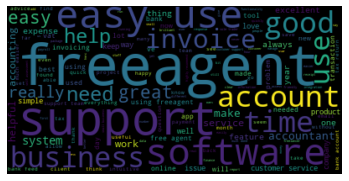

<Figure size 432x288 with 0 Axes>

In [10]:
# For starters, how about a simple word cloud?
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import functools

# get the data by just appending all the reviews together
reviews = fused_df.review.to_list()

# Rudimentary Cleaning
def rudCleanString(string):
    cleanedDotsLower = string.lower().replace(".", "")
    cleanedCommas = cleanedDotsLower.replace(",", "")
    return " ".join(cleanedCommas.split())

# Rudimentary Cleaning
cleaned_reviews = list(map(lambda reviewString: rudCleanString(reviewString), reviews))

# Contract into a single string
apppendedReviews = functools.reduce(lambda base, new : base + new, cleaned_reviews)

wordcloud = WordCloud().generate(apppendedReviews)
# Plot cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()


This doesn't really give us that much. How about if we try to utilise Machine learning to see if there are any patterns for a given review?

In [14]:
# Further cleaning and Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Clean for stop words (in the effort of reducing sparsity)
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(reviews)
vec.get_feature_names()[-100:] # Inspect some of the features

feature_names = vec.get_feature_names()

# Get Dims so far; quite sparse matrix so prob good to chill on the ngrams a bit.
X

<1119x3223 sparse matrix of type '<class 'numpy.float64'>'
	with 18297 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.decomposition import NMF

model = NMF(n_components=20, init='random', random_state=42)
W = model.fit_transform(X)
H = model.components_

# Util method lifted from sckit-doc
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(H):
        message = "Component #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# Let's check out some of the most heavily weighed features
print_top_words(model, feature_names, 12)

Component #0: 039 ve wouldn freeagent just couldn set account awesome used bank things
Component #1: easy use understand recommended reliable really super comprehensive staff keeps thanks access
Component #2: good far really services customer required help app new pleased reports experience
Component #3: software accounting brilliant best definitely company just piece needs better small ve
Component #4: excellent recommend freelancer knowledge work services providing accounts features simply questions advice
Component #5: helpful staff agent problem team knowledgeable extremely professional resolution advice queries quick
Component #6: makes easier life accounting breeze running invoicing day sme track easy doddle
Component #7: freeagent love recommend using years highly ve recommended app used efficient bookkeeping
Component #8: product best team class responsive functionality market awesome return ask ease company
Component #9: accounts like bank invoices free really need agent vat d

# Is there a lesson here?
Well, maybe. Just looking at the highly weighed words for each component does not yield any parituclarly useful conclusions. There seems to be a general positivity attached to ease-of-use/UI/UX and customer service/support. 


One thing we have yet to do if see if there is a noticbly difference if we were to limit ourselves to reviews with only a particular rank. Seeing as our classes (ranking) are quite unbalanced, we will merge 1:s, 2:s, and 3:s to try to get closer to the amount of 5:s. We will thus be focusing on the most satisfied and the least satisfied, go through the process again of NMF for each of these subsets, and see if there is anything intersting.

In [18]:
""" STARTING WITH THE POSITIVES """
# Slicing up into subsets
warm_reviews = fused_df.loc[fused_df["rating"] == 5].review

# Let's vectorize the warm feedback
warm_vectorizer = TfidfVectorizer(stop_words="english")
warm_reviews_vec = warm_vectorizer.fit_transform(warm_reviews)
warm_review_feature_names = warm_vectorizer.get_feature_names()

# Now to init our model
warm_model = NMF(n_components=15, init='random', random_state=42)
W = warm_model.fit_transform(warm_reviews_vec)
H = warm_model.components_

# Let's check out some of the most heavily weighed features
print_top_words(warm_model, feature_names, 10)


Component #0: mailing expectations drive copying calculates comms organised main remain assets
Component #1: graphic drive ago reading remain considerable 50k efficient choosing contrary
Component #2: contributed rbs queue main matching car parking realised formula lose
Component #3: numbers clicking engineers duper desciption breadth places reached arms real
Component #4: player powerful clicking desciption drive hosting designer miles plain numbskulls
Component #5: dashboards layer frankly drop regarding numbskulls lifetime letter developer open
Component #6: outgrowing 500 duper reaching improvement little calculates arms forgive afraid
Component #7: growth contrary gain 500 attention moved flaws program oriented collaboratively
Component #8: exciting listening mile presents list letter accurate lance affordable leading
Component #9: 01785 reasonably drive remain reading reach lose rely forgive collaboratively
Component #10: problem nat estimation authorised professional explanation

# Crítica part 1: what are the positives?
Again, we are running into the limits of the usefulness of matrix factorisation tecniques in the context of NLP. Taking only the full-star reviews in, we are not able to naively spot anything of particular interest; even after playing around with hyperparams.

In [19]:
""" NOW WITH THE NEGATIVE (<=3) """
# Slicing up into subsets
cold_reviews = fused_df.loc[fused_df["rating"] < 4].review
print("n of coldreviews: " + str(len(cold_reviews)))

# Let's vectorize the cold feedback
cold_vectorizer = TfidfVectorizer(stop_words="english")
cold_reviews_vec = cold_vectorizer.fit_transform(cold_reviews)
cold_review_feature_names = cold_vectorizer.get_feature_names()

# Now to init our model
cold_model = NMF(n_components=20, init='nndsvda', random_state=42)
W = cold_model.fit_transform(cold_reviews_vec)
H = cold_model.components_

# Let's check out some of the most heavily weighed features
print_top_words(cold_model, feature_names, 10)

n of coldreviews: 100
Component #0: 03 billing cheaper backbone 29 design 44b11yog fress answer generates
Component #1: faced accept banking easy everyday assessments ask discounts director competitor
Component #2: dismissed forwards books advocate grey credits community assistant eternal bs
Component #3: double claire effortless column additionally euro explained buts employees evening
Component #4: driver gives guess awkward class curve 2nd cheaper debits gross
Component #5: boring advocate cashflow attached advantage forwards competitive granular bpt clumsy
Component #6: absolute chatbot given freindly andrea band charged addressed guide exc
Component #7: freelancers adobe defeats drop good downsides freshbooks cloud gray daily
Component #8: agency annum flagged general fields edinburgh brilliant bring cleaning credit
Component #9: came days electronic afraid bugs choose article guess duties basic
Component #10: alan given air bundled 2012 andr dn buttons enjoying calls
Component #1

# Crítica part 2: negatives on the other hand...
While we are dealing with a quite limited dataset when it comes to negative reviews (just 100 to be exact), we are able to spot a couple of things. Component 1 does seem to indicate a pressence of negative review relating to billing and the price of the serviec. Beyond that, it is really hard to identify any sort of general pattern. 

While we could go further with the unsupervised methods, perhaps amending our limited data cleaning, at the look of it, there seems to be a limited knowledge to be gained by investing more time into unsupervised learning EDA. This is not too suprising as perhaps a less ML driven approach would work better given 1) the small dataset 2) the more general task of looking for trends.

One such trend, and a completely new dimension to the data that we haven't incoperated, is the reviews over time. We will do so below.

# Critíca part 3: what about reviews over time?

In [20]:
# Minor data cleaning to make sure all timestamps are in the same format
from datetime import datetime

example_time_str = io_reviews_df.t.to_list()[0]
print("timestamp example: " + example_time_str)

# Get correct conversion for time in io_reviews (into native python struct)
datetime_object = datetime.strptime(example_time_str, '%Y-%m-%d %H:%M:%S')
datetime_object

# Do the same for trustpilot timestamp
example_trustpilot_stamp = pilot_reviews_df.t.to_list()[0]
cleaned_tp_stamp = example_trustpilot_stamp.replace("T", " ").replace("Z", "")
print("timestamp example: " + cleaned_tp_stamp)

datetime_tp_stamp = datetime.strptime(cleaned_tp_stamp, '%Y-%m-%d %H:%M:%S')

# custom cleaning method for easier mapping:
def purifyTimestmaps(series):
    """ Takes in a series of str timestamps and converts them to python3 native datetime obj:s """
    removedCharacters = series.map(lambda timestring: timestring.replace("T", " ").replace("Z", ""))
    return removedCharacters.map(lambda charlessTimestring: datetime.strptime(charlessTimestring, '%Y-%m-%d %H:%M:%S'))

fused_df["datetime"] = purifyTimestmaps(fused_df.t)
fused_df[["datetime", "discrete_rating"]]

timestamp example: 2020-01-30 09:40:00
timestamp example: 2020-01-31 16:22:38


,datetime,discrete_rating
0,2020-01-30 09:40:00,5
1,2020-01-30 09:38:22,5
2,2020-01-21 09:47:17,4
3,2020-01-09 10:01:44,5
4,2020-01-08 06:20:09,5
5,2020-01-07 12:32:28,5
6,2020-01-05 11:44:07,5
7,2020-01-03 10:24:58,5
8,2019-12-12 19:43:34,2
9,2019-12-11 10:22:35,5


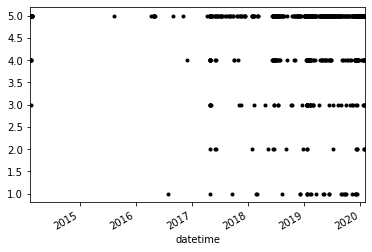

In [21]:
# let's plot it! Unfortunetely we can't rely on seaborn for this so we'll have to employ good ol' matplotlib
from matplotlib import pyplot

timeseries = fused_df[["datetime", "rating"]].set_index("datetime").rating
timeseries.plot(style="k.")
pyplot.show()

# That looks... interesting?
Needsless to say, our naive plotting is a bit of a mess. As the service gets more popular, more reviews will surely start coming in (more usage after all), so the thickening of lines is not very suprising. What could be a potentially interesting thing to look at is the proportion of reviews for each scale point (1 out of 5) for each year. This would account for the increased adoption of technology. Before we check this however, should we just look at the general number of reviews as well as the historically mean rating?

In [22]:
# Further Slicing
general_subset = fused_df[["datetime", "rating"]]

# Get monthly averages
general_subset.datetime = pd.to_datetime(general_subset.datetime)
general_subset = general_subset.set_index('datetime')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


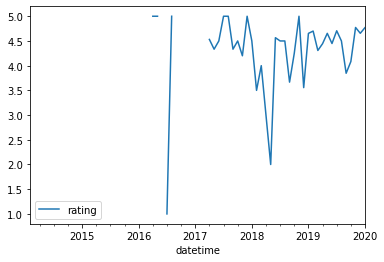

In [23]:
# Further Slicing
subset = fused_df[["datetime", "rating"]]

# Get monthly averages
subset.datetime = pd.to_datetime(subset.datetime)
subset = subset.set_index('datetime')
monthly_average_rating = subset.resample('M').mean()

# Drop NA:s or use scatter plot
monthly_average_rating.plot(kind='line')

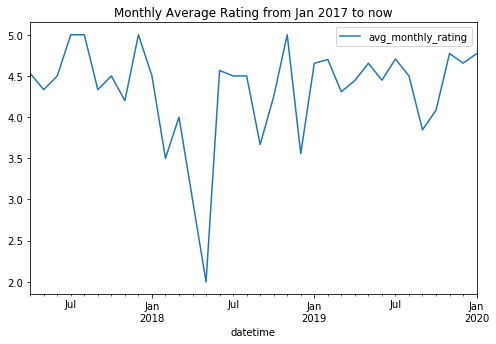

In [25]:
# Still incredibly messy with flawed gaps so lets drop NA:s and try to only look past 2017
cleaned_averages = monthly_average_rating.dropna()
new_timeline = cleaned_averages.loc['2017-01-01':'2020-12-30']
new_timeline.columns = ["avg_monthly_rating"]
new_timeline.plot(kind='line', title="Monthly Average Rating from Jan 2017 to now", figsize=(8,5))

# What happened after January of 2018?
One might wonder what happened in early-to-mid 2018. Given a tiny bit of research, it is possible to theorise one possible link: https://www.insider.co.uk/news/freeagent-bought-by-rbs-bidco-12258302

FreeAgent was the first aquisition made by RBS or any of its subsidiaries since the 2008-09 financial crisis and the company was aquired for an astonishing 75 Million pound price tag. One could theorise that things were rocky from a quality point of view, or perhaps that quality assurance was not a top priority as aquisition was looming/planned/negotiated.

Before making any such hypothesis, we should also check the amount of ratings recieved each months, as volatility of an average tends to be higher for smaller samples. If anything, this would afford us with a bit of perspective...

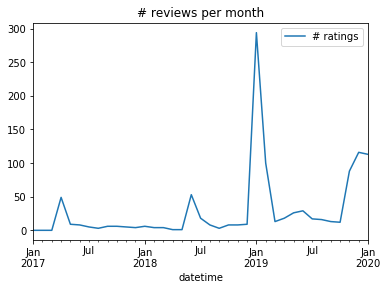

In [26]:
# Get number of reviews per month (not value counts just pure count) and plot monthly.
n_monthly_reviews = general_subset.resample('M').count()
n_monthly_reviews.columns = ["# ratings"]
# Again, only focus on past 2017 outcomes:
new_timeline = n_monthly_reviews.loc['2017-01-01':'2020-12-30']

new_timeline.plot(kind="line", title="# reviews per month")

## Spikes in places

While we are seeing some spikes, we are not seeing anything around the time of the major decline in avg. review score.
In a way, this is good thing. A sudden influx of one-sidingly negative reviews might be a indicator of a targeted attack by an outside actor. At this point though, things seem quite real, which unfortunetely indicates that the drop in avg. review score could be intepreted as a drop in quality/customer-service.

## Conclusion

For now, we can't make any extended conclusions other then the sudden drop in quality/customer-service, after which the acquisition by RBS followed. Correlation does not imply causation though, so at this time is simply a pattern that we might want to have a closer look at it.